In [1]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from utils.ImgOp import imshow

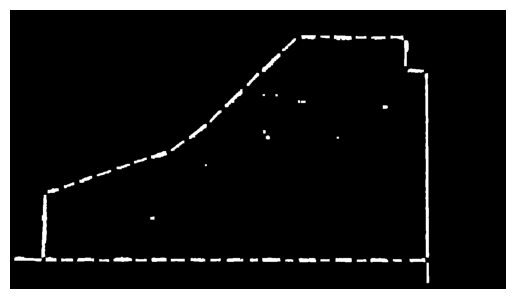

In [2]:
# 读取图像
img = cv2.imread('./saveImg/raw.jpg')

# 转换为 HSV 颜色空间
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

red_lower1 = np.array([0, 70, 50])
red_upper1 = np.array([10, 255, 255])
red_lower2 = np.array([170, 70, 50])
red_upper2 = np.array([180, 255, 255])

mask1 = cv2.inRange(hsv_img, red_lower1, red_upper1)
mask2 = cv2.inRange(hsv_img, red_lower2, red_upper2)
red_mask = mask1 + mask2

# 使用形态学操作去除噪点
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)

imshow(red_mask)

choose_pake: 根据图片特征人为选取车库位置,通过固定的顶点绘制区域


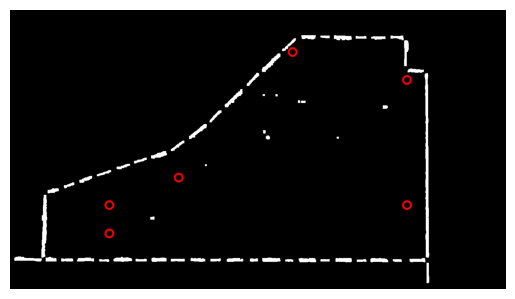

choose_pake: 绘制车库mask


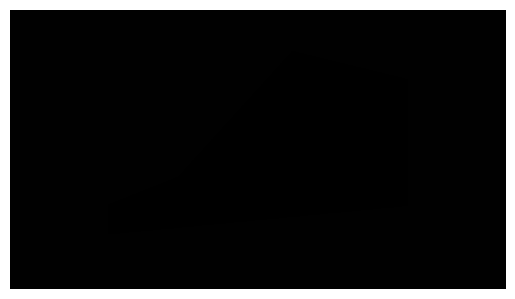

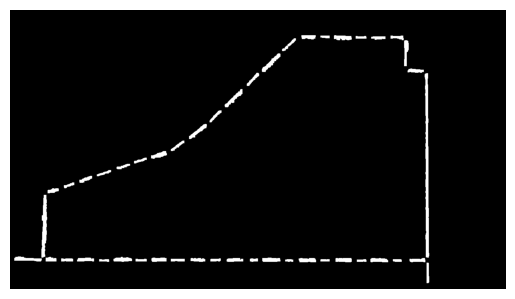

In [3]:
rows, cols = red_mask.shape[:2]
pot1 = [cols*0.2, rows*0.8]
pot2 = [cols*0.2, rows*0.7]
pot3 = [cols*0.34, rows*0.60]
pot4 = [cols*0.57, rows*0.15]
pot5 = [cols*0.8, rows*0.25]
pot6 = [cols*0.8, rows*0.7]
vertice = np.array([[pot1, pot2, pot3, pot4, pot5, pot6]], dtype = np.int32)
cp_image = red_mask.copy()
cp_image = cv2.cvtColor(cp_image, cv2.COLOR_GRAY2BGR)  # 灰度转BGR
for pt in vertice[0]:
    cv2.circle(cp_image, (pt[0], pt[1]), 10, (0, 0, 255), 4)  
    # 绘制位置,参数（图，图标大小，线粗细，颜色，图标编号）
print('choose_pake: 根据图片特征人为选取车库位置,通过固定的顶点绘制区域')
imshow(cp_image)

mask = np.ones_like(red_mask)
if len(mask.shape) == 2:
    cv2.fillPoly(mask, vertice, 0)
    print('choose_pake: 绘制车库mask')
    imshow(mask)
image_choose_pake = cv2.multiply(cv2.bitwise_and(red_mask, mask), 255)
imshow(image_choose_pake)

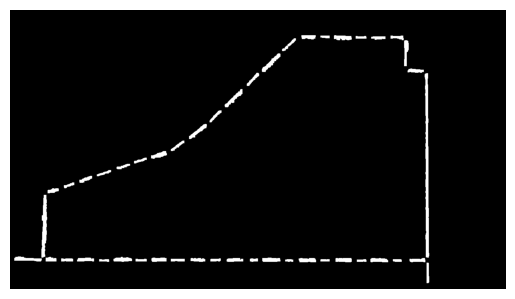

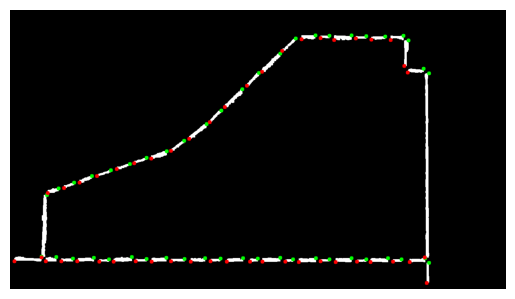

In [4]:
image = image_choose_pake.copy()
imshow(image)
# 寻找轮廓
contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# 找到所有连通分量的最左下方和最右上方的点
components = []
for contour in contours:
    left = min(contour[:, 0, 0])
    right = max(contour[:, 0, 0])
    bottom = min(contour[:, 0, 1])
    top = max(contour[:, 0, 1])
    
    components.append([[left, top], [right, bottom]])
result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
# 输出每个连通分量的最左下方和最右上方的点
for i, (c1, c2) in enumerate(components):
    cv2.circle(result, c1, 5, (0, 0, 255), -1)
    cv2.circle(result, c2, 5, (0, 255, 0), -1)
imshow(result)

In [5]:
len(components)

47

In [21]:
from models.Nodes import *

Nodes = read('./config/data.json') 
Nodes_road = [x for x in Nodes if x.is_parking == 0]
Nodes_lot = [x for x in Nodes if x.is_parking == 1]

with open("./config/edge.txt", 'w') as f:
    for c1, c2 in components:
        L = Get_Nearest_Node(Nodes_road, c1)
        R = Get_Nearest_Node(Nodes_road, c2)
        f.write(f"{L}  {R}\n")
    for node in Nodes_lot:
        Nodes_up = [x for x in Nodes if x.y < node.y]
        Nodes_dn = [x for x in Nodes if x.y > node.y]
        U = Get_Nearest_Node(Nodes_up, node)
        D = Get_Nearest_Node(Nodes_dn, node)
        f.write(f"{U}  {node.id}\n")
        f.write(f"{D}  {node.id}\n")

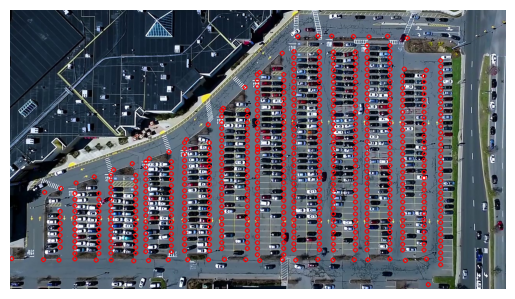

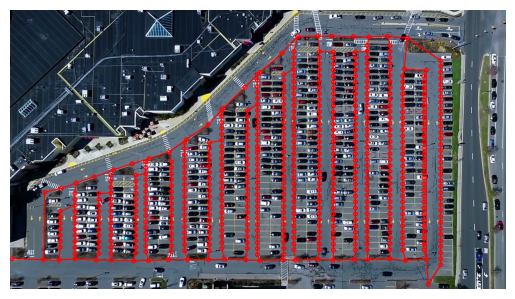

In [22]:
image_test = cv2.imread("./saveImg/scene1380.jpg")

dic = {}
for node in Nodes:
    dic[node.id] = node
    cv2.circle(image_test, (int(node.x), int(node.y)), 5, (0, 0, 255), thickness=2)
imshow(image_test)

edges = []

with open("./config/edge.txt", "r") as f:
    for line in f:
        edges.append(map(int, line.strip().split()))

for x, y in edges:
    cv2.line(image_test, (int(dic[x].x), int(dic[x].y)), (int(dic[y].x), int(dic[y].y)), 
             (0, 0, 255), thickness=2)
imshow(image_test)

In [16]:
len(edges)

585